In [1]:
# AE(auto encoder)
    # encoder : 특징추출과정(차원축소)
    # decoder : 데이터 원형 복원과정(차원확대)
    #입력과 출력이 동일(100%동일 하다는 것이 아니고 목표가 동일하다.)
    #dense로 차원축소 후 차원확대
    #pca 와 일치한다. activation을 사용하지 않으며(선형으로 이루어져 있다.)

In [ ]:
# 차원축소 - 시각화
#activation - 비선형에 매핑

In [5]:
import tensorflow as tf
import numpy.random as rnd
import numpy as np
rnd.seed(4)
m = 200 #200개의 데이터
w1,w2 = 0.1,0.3
noise = 0.1
#데이터를 규칙적으로 만들기위해서 생성하고 있다. - 함수화 + 노이즈추가

angles = rnd.rand(m) * np.pi/2 -0.5
data = np.empty((m,3))
#200개의 데이터를 3차원으로 만들었다.
data[:,0] = np.cos(angles)+np.sin(angles)/2+noise*rnd.randn(m)/2 #데이터에 주기성을 주었다.(회전)
data[:,1] = np.sin(angles)*0.7 + noise*rnd.randn(m)/2
data[:,2] = data[:,0]*w1 + data[:,1]*w2 + noise*rnd.randn(m)
print(np.shape(data))

(200, 3)


In [6]:
from sklearn.preprocessing import StandardScaler
# z점수 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100]) #fit할때 평균,표준편차를 찾고 transform 데이터 변환
X_test = scaler.transform(data[100:])

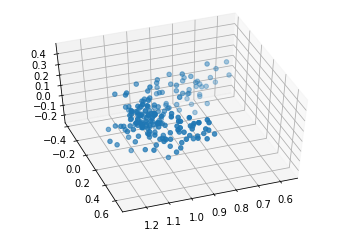

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
ax = plt.axes(projection = '3d')
ax.scatter3D(data[:,0], data[:,1], data[:,2])
ax.view_init(azim=70, elev=50) #azim = 카메라에 좌우회전, elev = 상하

In [13]:
import numpy as np
def reset_graph(seed=42):
    #그래프 초기화(중복해서 동일 변수를 생성하지 못하기 때문에)
    tf.reset_default_graph() #dnn은 operation구조를 그래프로 표현한다.(일처리를 하기위한 자료구조가 graph이다.)
    tf.set_random_seed(seed)
    np.random.seed(seed)
from tensorflow.python.framework import ops
ops.reset_default_graph() #위와 같은것

In [17]:
import tensorflow as tf
reset_graph()
n_input = 3 #200*3 데이터
n_hidden = 2 #2개의 특징추출
n_outputs = n_input #출력차수(원래의 모습으로 복원하기 위해 input과 동일)
learning_rate = 0.01
X = tf.placeholder(tf.float32, shape=[None, n_input])
#100*3 (train)
#dense 자동으로 가중치를 생성한다.
hidden = tf.layers.dense(X, n_hidden) #가중치 = 3*2 -> 데이터 사이즈 = 100*2
outputs = tf.layers.dense(hidden, n_outputs) #가중치 = 2*3 -> 데이터 사이즈 = 100*3
reconstruction_loss = tf.reduce_mean(tf.square(outputs-X)) #cost function = MSE로 잡고있다. (예측값과 실제값의 차이를 보고있다.)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss) #손실을 최소화 하는 방향으로 학습한다.
init = tf.global_variables_initializer() #초기화

In [22]:
n_iterations = 1000 #1000번을 돈다.
codings = hidden #2
with tf.Session() as sess:
    init.run()
    #반복 = epoch
    for iteration in range(n_iterations):
        #1000*100(개의데이터)
        training_op.run(feed_dict={X:X_train})
    codings_val = codings.eval(feed_dict={X:X_test}) #test데이터를 eval하였다.
    #특징추출된 차원축소된 데이터를 시각화에 사용한다.

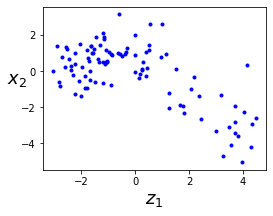

In [23]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:,1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18, rotation=0)
plt.show('선형 Auto encoder(AE)')

In [ ]:
#양끝의 데이터의 차이가 줄어드는 방향으로 학습을 하다보면 양끝의 데이터가 같아진다.
#특징을 추출 - 차원을 축소

In [ ]:
#denoise auto encoder
    #입력데이터 + noise를 섞어서 학습하고있다.

In [34]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#matplotlib 여러가지를 동시에 출력하기 위해서 사용
reset_graph()

In [35]:
def vis(images, save_name):
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
    #행렬로 화면을 구성한다.
    gs = gridspec.GridSpec(n_image_rows,n_image_cols,top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)
    for g,count in zip(gs,range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count,:].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(save_name + '_vis.png')
    plt.show()

In [36]:
mnist_width = 28
n_visible = mnist_width * mnist_width
n_hidden = 500
corruption_level = 0.3 #masking하는 정도를 얘기한다. - masking(가린다.)
#가리는 부분은 이미지가 삭제된다.

# create node for input data
X = tf.placeholder("float", [None, n_visible], name='X')
# create node for corruption mask
mask = tf.placeholder("float", [None, n_visible], name='mask') #0,1로 구성이 되어있다.(0이있는 부분의 이미지를 없애는 것)

# create nodes for hidden variables
W_init_max = 4 * np.sqrt(6. / (n_visible + n_hidden)) #가중치 784*500 (n_hidden=500)
W_init = tf.random_uniform(shape=[n_visible, n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)

W = tf.Variable(W_init, name='W') #784*500
b = tf.Variable(tf.zeros([n_hidden]), name='b') #나가는 차수만큼 바이어스를 생성

In [37]:
#가중치 전치시켰다.
W_prime = tf.transpose(W)  # tied weights between encoder and decoder, 500*784
#가중치를 차원축소와 차원확대에 공유하여 사용하였다.
b_prime = tf.Variable(tf.zeros([n_visible]), name='b_prime') #바이어스는 새로만들었다.


def model(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask * X  # 128장*784 , 가중치(784*500), 나가는놈 128*500 
    #요소곲(행렬곱x) 0이있는 부분은 이미지가 삭제된다.
    #이미지가 일부삭제된 원본 이미지 사이즈가 된다.
    #원래데이터를 그냥 집어넣는게 아니라 원래데이터의 일부를 마스킹한다. -> noise를 준다.
    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)  # hidden state
    #128*784 * 784*500 -> 원래 이미지로 회복된다.
    #원래이미지를 전치시켜 놓으면 특징을 추출했다가 원래 이미지로 회복한다.
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)  # reconstructed input
    #128*784
    return Z

# build model graph
Z = model(X, mask, W, b, W_prime, b_prime) #복원된 이미지 reconstruct 재구상된 이미지가 된다.

# create cost function
cost = tf.reduce_sum(tf.pow(X - Z, 2))  # minimize squared error
#원래의 이미지와 재구상된 이미지의 차를 더했다.

train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost)  # construct an optimizer
predict_op = Z
# load MNIST data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [38]:
# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()

    for i in range(100):
        for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
            input_ = trX[start:end]
            #2항분포 (0,1) : 어느정도를 0으로 할것인가를 결정
            mask_np = np.random.binomial(1, 1 - corruption_level, input_.shape)
            sess.run(train_op, feed_dict={X: input_, mask: mask_np})

        mask_np = np.random.binomial(1, 1 - corruption_level, teX.shape)
        print(i, sess.run(cost, feed_dict={X: teX, mask: mask_np}))
    # save the predictions for 100 images
    mask_np = np.random.binomial(1, 1 - corruption_level, teX[:100].shape)
    predicted_imgs = sess.run(predict_op, feed_dict={X: teX[:100], mask: mask_np})
    input_imgs = teX[:100]

0 110717.66
1 96203.695
2 88683.75
3 81698.63
4 76894.266
5 75731.75
6 71581.64
7 70653.83
8 69025.79
9 68168.305
10 67475.94
11 66054.0
12 66448.33
13 64350.555
14 64234.344
15 63733.68
16 63919.016
17 63081.574
18 62212.434
19 62374.13
20 62163.57
21 61970.39
22 61278.453
23 61227.703
24 61441.24
25 61330.78
26 61825.035
27 60590.906
28 60872.105
29 60236.465
30 60662.547
31 60360.223
32 60037.453
33 59607.53
34 61008.31
35 60034.82
36 59019.312
37 59066.01
38 59781.15
39 59958.117
40 59482.285
41 59197.62
42 58740.23
43 58724.195
44 59025.75
45 59257.883
46 58528.266
47 57656.61
48 58432.46
49 58502.02
50 57827.82
51 58269.996
52 57976.984
53 58142.96
54 57822.32
55 58199.707
56 57578.5
57 58791.04
58 57896.066
59 57649.55
60 57598.58
61 57453.73
62 57103.13
63 57272.117
64 58054.836
65 57418.965
66 57629.2
67 57131.99
68 57286.375
69 57601.5
70 57549.758
71 58295.508
72 56931.91
73 57617.95
74 57294.25
75 57207.133
76 57167.195
77 56804.098
78 56576.23
79 56365.1
80 57330.45
81 567

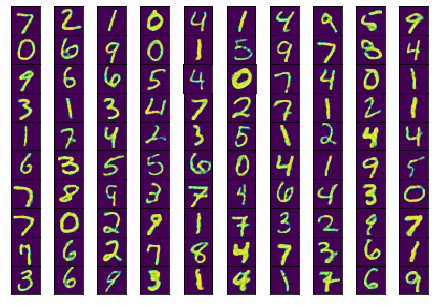

In [39]:
# Plot the reconstructed images
vis(predicted_imgs,'pred') #예측한 이미지 : 특징추출으로 생성된 이미지

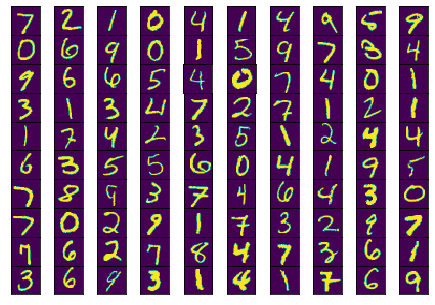

In [40]:
# Plot input images to compare with
vis(input_imgs,'in') #입력한 이미지 : 원래 입력이미지

In [62]:
#VAE
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops
ops.reset_default_graph()
from functools import partial 
#partial 매개변수 일부분을 고정시킬때 사용한다.

reset_graph()

n_inputs = 28*28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20 #20개의 mean과 sigma
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs #784 복원차수

learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer() #1이 넘어가지 않도록 초기화 진행
my_dense_layer = partial(tf.layers.dense, activation = tf.nn.relu, kernel_initializer=initializer) #매개변수를 fix시키는것
#함수의 매개변수를 고정한 값을 변수에 담아서 그것을 함수로 사용한다.(customize한 함수)
X = tf.placeholder(tf.float32, [None, n_inputs]) #150*784
hidden1 = my_dense_layer(X,n_hidden1) #784*500(가중치), 150*500(출력데이터)
hidden2 = my_dense_layer(hidden1,n_hidden2) #150*500(입력데이터), 500*500(가중치), 150*500(출력데이터)

#찾는 평균, 표준편차는 분포의 평균, 표준편차(activation=None)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None) #20개의 특징을 잡는다. 가중치(500*20), 출력데이터(150*20)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None) #20개의 특징을 잡는다. 가중치(500*20), 출력데이터(150*20)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype = tf.float32) #정규분포로 랜덤 노이즈 발생
#같은 값에 noise를 곱해서 sigma를 만든다.

hidden3 = hidden3_mean+hidden3_sigma*noise #분포를 학습하기 위해서 , 150*20
#잠재변수를 : 평균과 표준편차에 z점수를 구해서, 정규분포에서 구한값으로 변동성을 부여한다.
hidden4 = my_dense_layer(hidden3, n_hidden4) #가중치(20*500), 출력데이터(150*500)
hidden5 = my_dense_layer(hidden4, n_hidden5) #가중치(500*500), 출력데이터(150*500)
logits = my_dense_layer(hidden5, n_outputs, activation=None) #가중치(500*784) 출력데이터(150*784)
outputs = tf.sigmoid(logits) #확률값으로 변경
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits) #확률을 이용한 불순도 검사
reconstruction_loss = tf.reduce_sum(xentropy) #다 합해서 재구성 오차값을 만든다.(재구성했을때의 차이값)

In [63]:
#정규분포와 일치하는지에 대한 오차값을 구한다.
eps = 1e-10 #엡실론상수를 얘기한다.(log는 0이되면 무한대가 된다. 무한대로 가는것을 막기위해 엡실론 상수값을 주었다.)
latent_loss = 0.5*tf.reduce_sum(tf.square(hidden3_sigma) + tf.square(hidden3_mean) -1 -tf.log(eps + tf.square(hidden3_sigma)))
#0.5 미분했을때의 값을 제거하기 위해서
#잠재변수 손실값이 된다. -> 변동성을 갖추고 있다.

loss = reconstruction_loss + latent_loss #모두 고려한 총 손실
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [64]:
import sys
n_digits = 60
n_epochs = 50
batch_size = 150
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            #한세대에서 회전할 횟수
            print('\r{}%'.format(100*iteration // n_batches), end='')
            sys.stdout.flush() #버퍼를 다 출력시켜라 남겨진것 없이
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch}) 
            #비지도 학습으로 y값을 쓰지 않는다.(특징추출후 noise가 제거된 학습을 하기위해서, 
            #다중공산성을 없앤상태에서 학습을 하기위해서 특징추출)
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X:X_batch})
        print('\r{}'.format(epoch), '총손실 : ', loss_val, '재구성손실 : ', reconstruction_loss_val, '지연손실 : ', latent_loss_val)
        
    #test
    coding_rnd = np.random.normal(size=[n_digits, n_hidden3]) #60*20 노이즈를 입력(그냥 랜덤한 값의 노이즈를 입력하였다.)
    outputs_val = outputs.eval(feed_dict={hidden3 : coding_rnd}) #3번에 노이즈를 입력 (mean, sigma위치에 랜덤한 숫자들을 입력하였다.)
    #뒤의 hidden4, hidden5, output의 가중치가 정규분포에서 생성된 값을 hidden3에 넣으면 학습한값의 target 생성이가능하다. 
    #학습이 잘 이루어졌고, 랜덤으로부터 target을 생성하고 있다.
    #가중치로 부터 target을 생성하는 생성모델이다.

09% 총손실 :  22445.957 재구성손실 :  19948.494 지연손실 :  2497.4626
19% 총손실 :  21754.633 재구성손실 :  18851.887 지연손실 :  2902.7466
2 총손실 :  20075.963 재구성손실 :  17123.95 지연손실 :  2952.0132
3 총손실 :  21436.457 재구성손실 :  18304.133 지연손실 :  3132.3252
4 총손실 :  21145.957 재구성손실 :  18075.727 지연손실 :  3070.2302
5 총손실 :  19073.395 재구성손실 :  16010.803 지연손실 :  3062.5908
69% 총손실 :  19811.559 재구성손실 :  16746.703 지연손실 :  3064.8555
7 총손실 :  19094.904 재구성손실 :  15970.012 지연손실 :  3124.892
8 총손실 :  19619.742 재구성손실 :  16579.46 지연손실 :  3040.2808
9 총손실 :  17759.527 재구성손실 :  14860.29 지연손실 :  2899.2368
10% 총손실 :  17474.293 재구성손실 :  14673.65 지연손실 :  2800.6426
11% 총손실 :  16888.963 재구성손실 :  13990.953 지연손실 :  2898.0103
12% 총손실 :  16472.992 재구성손실 :  13374.594 지연손실 :  3098.3982
13 총손실 :  15985.108 재구성손실 :  13154.211 지연손실 :  2830.8975
14 총손실 :  16454.473 재구성손실 :  13564.695 지연손실 :  2889.777
15 총손실 :  16191.54 재구성손실 :  13297.475 지연손실 :  2894.0657
16% 총손실 :  16629.418 재구성손실 :  13722.34 지연손실 :  2907.0771
17 총손실 :  16144.56 재구성손실 :  13299.379 지

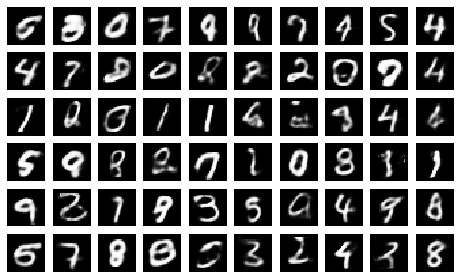

In [65]:
def plot_image(image,shape=[28,28]):
    plt.imshow(image.reshape(shape), cmap="gray", interpolation='nearest')
    plt.axis('off')
plt.figure(figsize=(8,50))
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration+1)
    plot_image(outputs_val[iteration])
plt.show()
#랜덤한 값으로 생성된 값을로 예측된(가중치로 학습된) image

In [66]:
#GAN (Generative adversarial network)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./mnist/data/', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [67]:
total_epoch = 100 #55000개가 100번 돌아간다.
batch_size = 100
learning_rate = 0.0002 #hyper parameter 값에 따라 accuracy가 변한다.

n_hidden = 256
n_input = 28*28
n_noise = 128
X = tf.placeholder(tf.float32, [None, n_input]) #100*784
Z = tf.placeholder(tf.float32, [None, n_noise]) #100*128

#생성기(두개의 레이어를 거치며 가중치를 학습한다.)
G_W1 = tf.Variable(tf.random_normal([n_noise, n_hidden], stddev=0.01)) #128*256(가중치 생성)
G_b1 = tf.Variable(tf.zeros([n_hidden]))
G_W2 = tf.Variable(tf.random_normal([n_hidden, n_input], stddev=0.01)) #256*784(가중치 생성)
G_b2 = tf.Variable(tf.zeros([n_input]))

#분별기(진짜이미지와 생성이미지를 구별해 내는것)
D_W1 = tf.Variable(tf.random_normal([n_input, n_hidden], stddev=0.01)) #784*256
D_b1 = tf.Variable(tf.zeros([n_hidden]))
D_W2 = tf.Variable(tf.random_normal([n_hidden, 1], stddev=0.01)) #256*1(참/거짓유무)
D_b2 = tf.Variable(tf.zeros([1]))

In [71]:
def generator(noise_x):
    #noise = 100*128, G_W1 = 128*256 -> 100*256
    hidden = tf.nn.relu(tf.matmul(noise_x, G_W1)+G_b1)
    #hidden = 100*256, G_W2 = 128*784 -> 100*784
    output = tf.nn.sigmoid(tf.matmul(hidden, G_W2)+G_b2)
    return output
def discriminator(inputs):
    #100*784 , D_W1=784*256 -> 100*256
    hidden = tf.nn.relu(tf.matmul(inputs, D_W1)+D_b1)
    #100*256 , D_W2=256*1 -> 100*1 서로 비교를 하기위해서 1이 나간다.
    output = tf.nn.sigmoid(tf.matmul(hidden, D_W2)+D_b2)
    return output
def get_noise(batch_size, n_noise):
    return np.random.normal(size=(batch_size, n_noise))

In [72]:
G = generator(Z) #생성기(noise를 매개변수로 넣어줌)
D_gene = discriminator(G) #100*1
D_real = discriminator(X) #100*1
#망은 연결이 되어있으나 학습은 별도로 진행된다.(왜냐 다른값이니까.)

In [77]:
#cross entropy = KL_divergence
loss_D = tf.reduce_mean(tf.log(D_real)+tf.log(1-D_gene)) #두개의 분별기의 값으로 loss값 도출
#생성한 값의 불순도
loss_G = tf.reduce_mean(tf.log(D_gene))

D_var_list = [D_W1, D_b1, D_W2, D_b2]
G_var_list = [G_W1, G_b1, G_W2, G_b2]

#최적화기 2개 -> 따로따로 학습한다.(두개의 분별기를 학습한다.)
train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D, var_list=D_var_list) #분별기에 해당되는 가중치만 변화한다.
#분류기의 성능 = 실제 이미지를 잘 구분할수록, 즉 실제이미지에 1에 가까운 수를 부여할 수록 좋다고 할 수 있다.
train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G, var_list=G_var_list) #생성기에 해당하는 가중치만 변화한다.
#생성기의 성능 = 자신이 만든 가짜 이미지를 분류기에 보여주었을때 1에 가까운 수를 부여할 수록 좋다고 할 수 있다.

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size) 
#평가하기 위해 loss값을 저장
loss_val_D, loss_val_G = 0,0

for epoch in range(total_epoch):
    #100번 학습
    for i in range(total_batch):
        #550번 학습
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)
        
        #discriminator(원본이미지와 노이즈가 합성된다.), generator(noise가 입력된다.)
        #두개의 학습모델이 다른 의미를 가지고 있다.
        #discriminator(분별기) - 두개의 이미지가 얼마나 같은지를 cross entropy를 통해서 학습한다. -> kull lib divergence
            #참일때 log값 거짓일때의 log값을 더해서
        _, loss_val_D = sess.run([train_D, loss_D], feed_dict={X: batch_xs, Z: noise}) # 구분자는 X 값을 받는다
        _, loss_val_G = sess.run([train_G, loss_G], feed_dict={Z: noise}) # 생성자는 노이즈Z 값을 받는다
        #생성기 - 원본이미지로 부터 학습된 가중치로 노이즈를 입력하여 이미지를 생성
        
        
        #분별기가 먼저 학습을 하고 생성기에 대해 진짜 생성을 하고 그때의 loss값을 구하게 된다.
        
    print('Epoch:', '%04d' % epoch, 'D loss: {:.4f}'.format(loss_val_D), 'G loss: {:.4f}'.format(loss_val_G))
    
    if epoch == 0 or (epoch+1)%10 == 0:
        #처음이거나 10번마다 돌아가면서 10개씩 노이즈를 만들어서 generator에서 생성해본다.(test해본다.)
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G, feed_dict={Z:noise}) #10*784 (확대된 이미지가 출력된다.)
        fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))
        for i in range(sample_size):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape(samples[i], (28,28)))
        plt.savefig('samples/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.close(fig)
print('최적화완료!')    
#입력데이터 = noise
#noise가 입력되었는데 이미지가 완성된다. 

In [ ]:
#추출된 특징이 화풍이 된다.
#특징이 +,- 연산이 가능하다. 연산하게 되면 연산된대로 이미지를 만들어낼 수 있게 된다.